In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install --quiet "pandas" "torch" "torchvision" "ipython[notebook]" "seaborn" "pytorch-lightning>=1.4" "torchmetrics>=0.6" "lightning-bolts" "torch-lr-finder" "grad-cam" "gradio" "torchinfo"

In [3]:
! git clone https://github.com/niharikavadapalli/ERA-V1.git

Cloning into 'ERA-V1'...
remote: Enumerating objects: 830, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 830 (delta 8), reused 15 (delta 6), pack-reused 808
Receiving objects: 100% (830/830), 45.49 MiB | 26.59 MiB/s, done.
Resolving deltas: 100% (407/407), done.


In [4]:
!git -C ERA-V1 pull

Already up to date.


In [5]:
import sys
sys.path.append("ERA-V1/ERA-V1-Session-13")

In [6]:
import utils.config as config
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader



from models.PL_yolov3 import LitYolov3
from models.yolov3 import YOLOv3
from tqdm import tqdm
from utils.utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples,
    plot_couple_examples_test
)
from PL_main import create_pl_model, train_pl_model, get_max_lr
from utils.loss import YoloLoss
from utils.datamodule import YOLODataModule
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [7]:
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)

In [8]:
def criterion(out, y):
    y0, y1, y2 = (
            y[0],
            y[1],
            y[2],
        )
    loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )
    return loss

In [9]:
loss_fn = YoloLoss()
model = create_pl_model(loss_fn, scaled_anchors, config.CONF_THRESHOLD,optimizer = None, scheduler=None, BATCH_SIZE=config.BATCH_SIZE, NUM_WORKERS=config.NUM_WORKERS, epochs=config.NUM_EPOCHS, image_size=config.IMAGE_SIZE, num_classes=config.NUM_CLASSES)
optimizer = optim.Adam(
    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)

In [10]:

# Define data module
dir_name = '../input/pascal-voc-dataset-used-in-yolov3-video/'
csv_files = [config.DATASET + "/train.csv", config.DATASET + "/test.csv"]
train_transforms=config.train_transforms
test_transforms=config.test_transforms
val_transforms = test_transforms
IMAGE_SIZE = config.IMAGE_SIZE
S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
img_dir=config.IMG_DIR
label_dir=config.LABEL_DIR
anchors=config.ANCHORS
yolo_dm = YOLODataModule(
                 csv_files,
                 img_dir,
                 label_dir,
                 anchors,
                 image_size=IMAGE_SIZE,
                 S=S,
                 C=20,
                 train_transforms = train_transforms,
                 val_transforms = val_transforms,
                 test_transforms = test_transforms,
                 val_split=0.1,
                 num_workers = config.NUM_WORKERS,
                 pin_memory = False,
                 batch_size = config.BATCH_SIZE)
yolo_dm.setup()
yolo_dm.setup(stage = 'test')

In [11]:
EPOCHS = 40
train_loader = yolo_dm.train_dataloader()
scheduler = OneCycleLR(
        optimizer,
        max_lr=1E-3,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )
model.set_optimizer_and_scheduler(optimizer,scheduler)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

=> Saving checkpoint


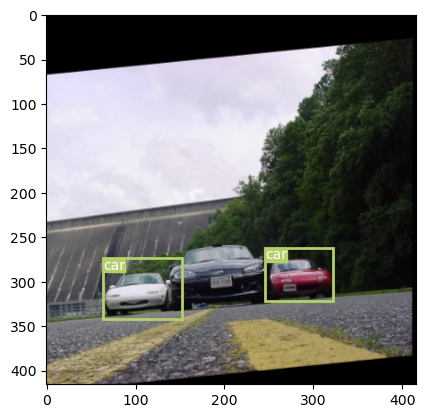

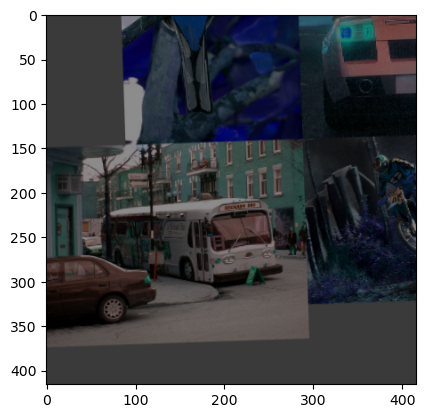

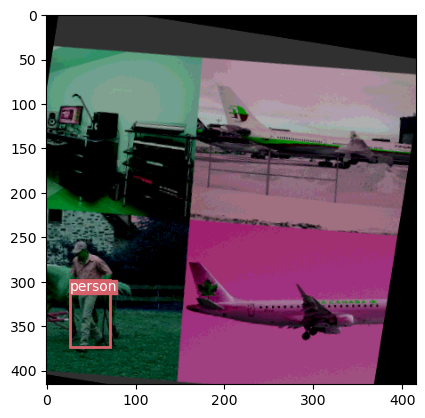

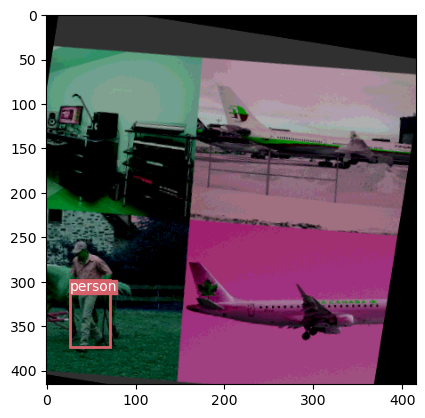

Model saved!


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

=> Saving checkpoint


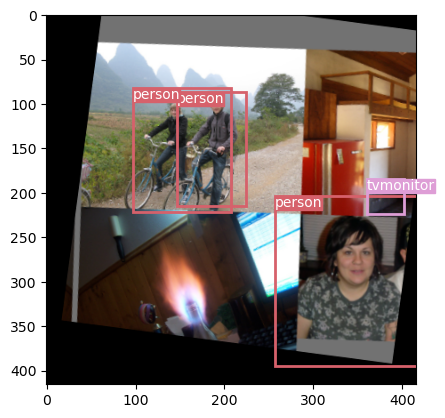

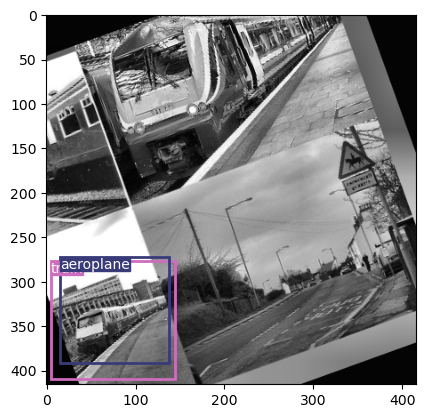

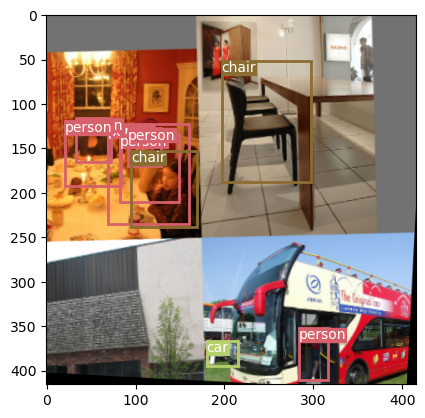

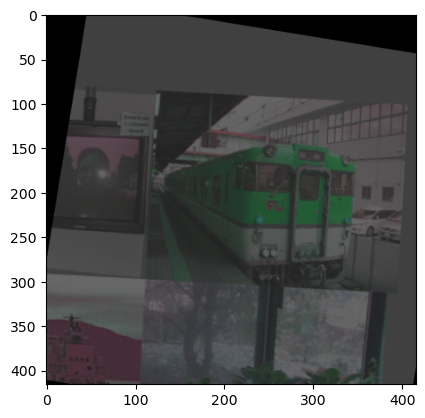

Model saved!


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

=> Saving checkpoint


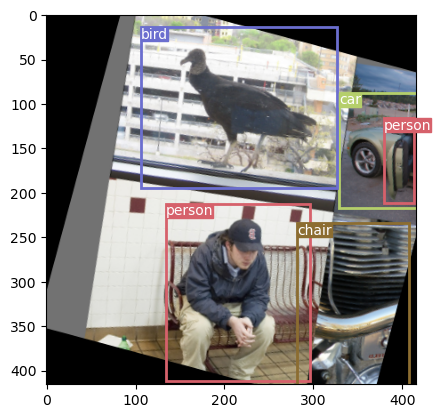

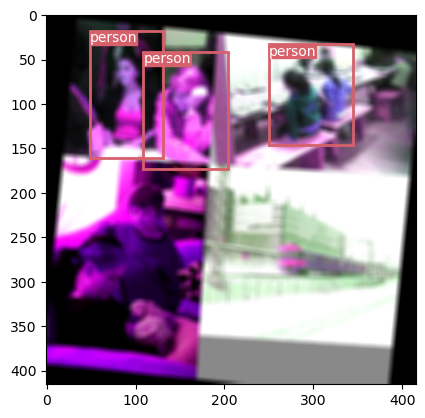

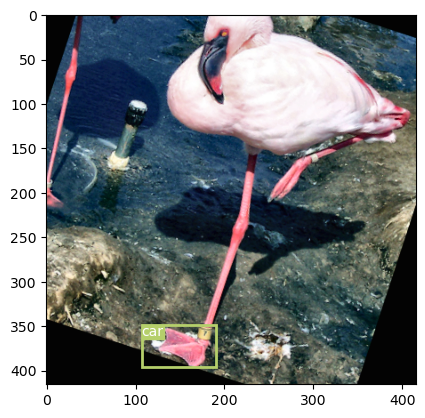

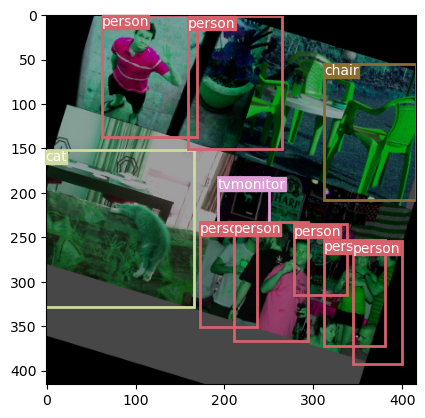

Model saved!


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

=> Saving checkpoint


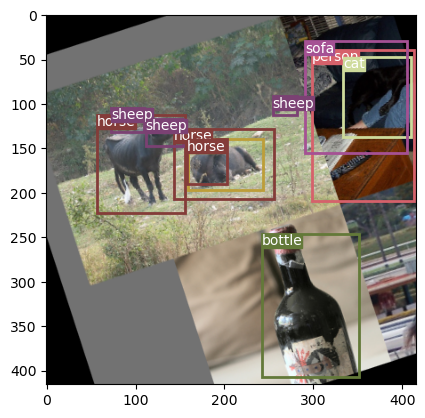

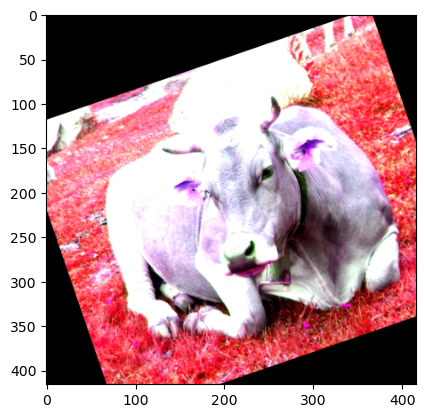

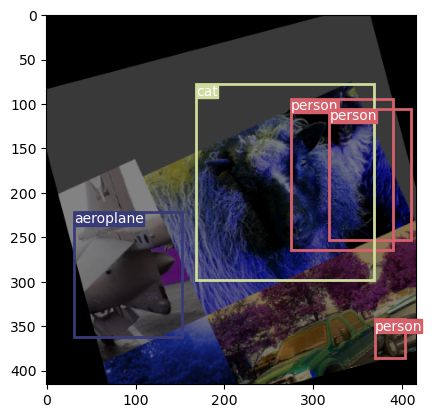

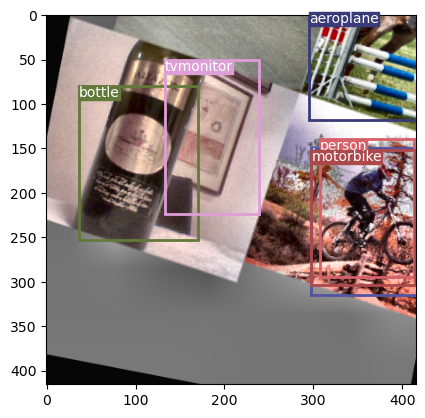

Model saved!


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

=> Saving checkpoint


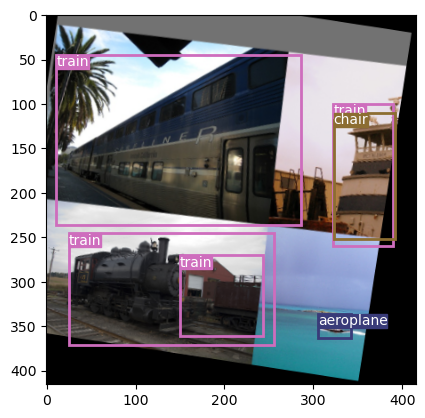

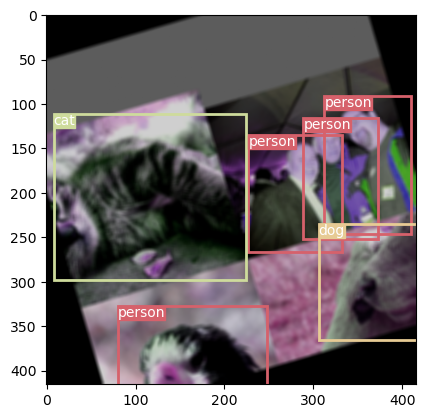

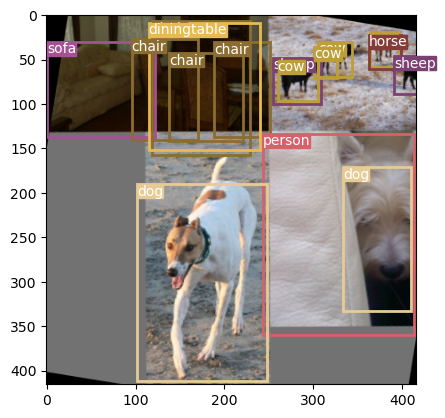

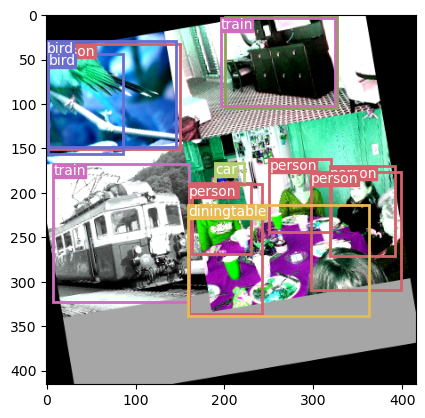

Model saved!


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

=> Saving checkpoint


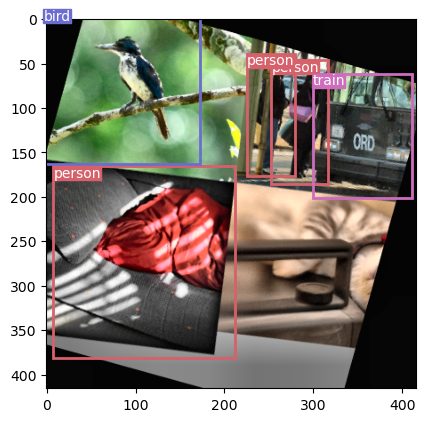

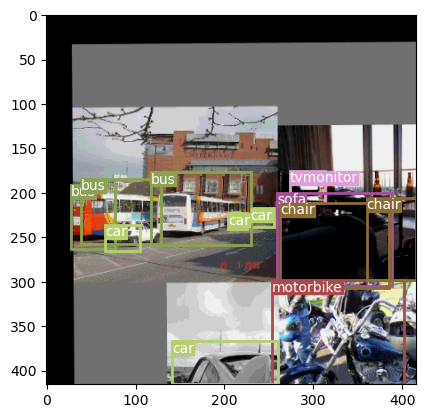

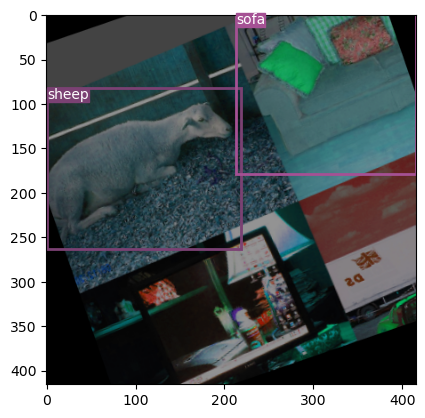

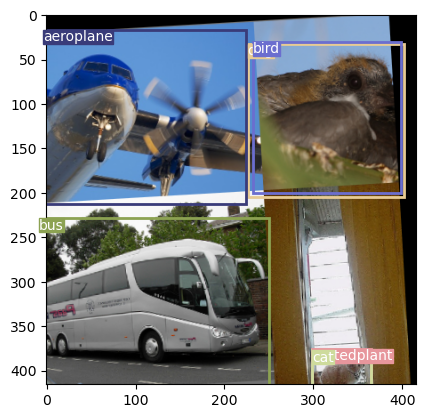

Model saved!


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

=> Saving checkpoint


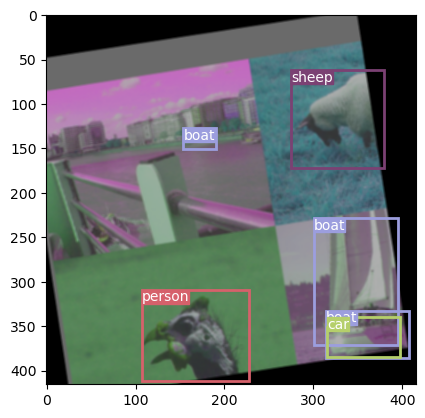

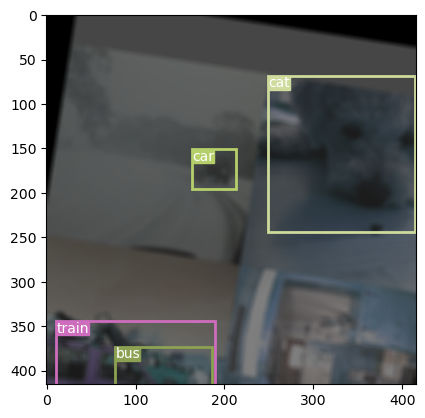

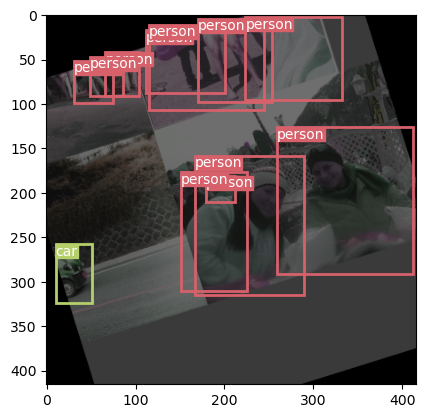

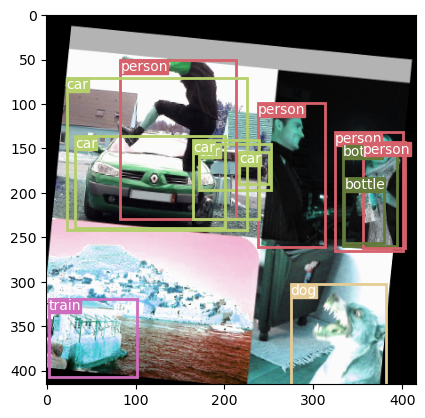

Model saved!


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

skipping save


Validation: 0it [00:00, ?it/s]

=> Saving checkpoint


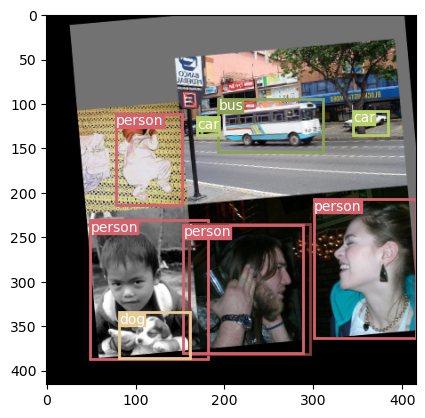

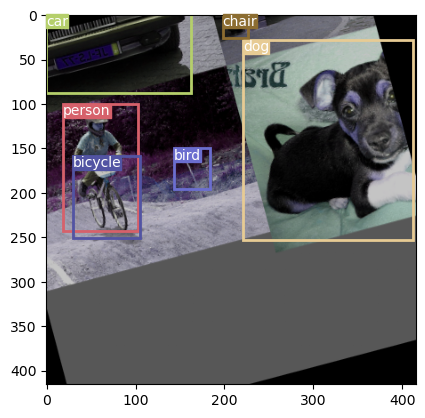

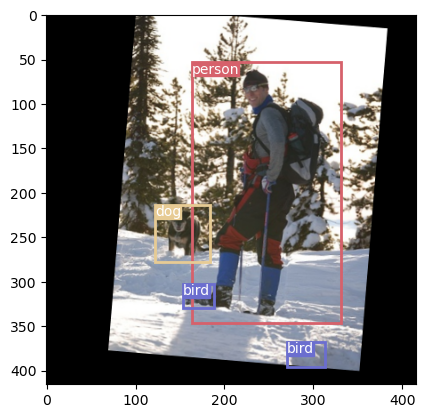

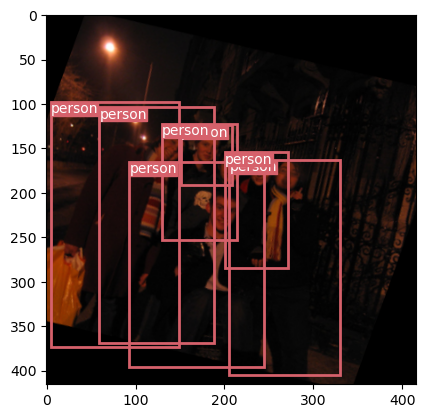

Model saved!


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_Class_Accuracy    │     89.06653594970703     │
│   test_No_Obj_Accuracy    │     99.00479888916016     │
│     test_Obj_Accuracy     │     70.31941223144531     │
└───────────────────────────┴───────────────────────────┘

In [12]:
trainer = train_pl_model(model, yolo_dm, epochs = EPOCHS)

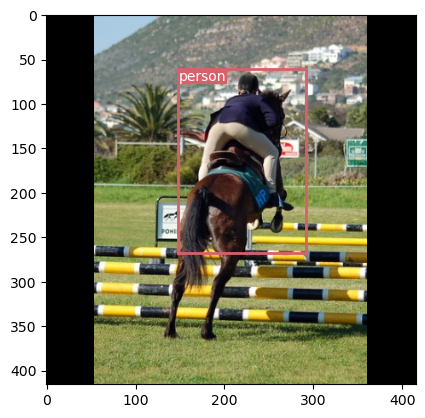

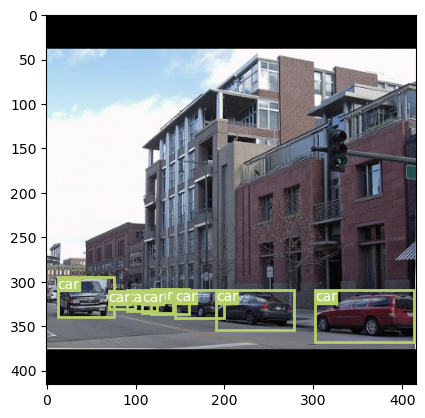

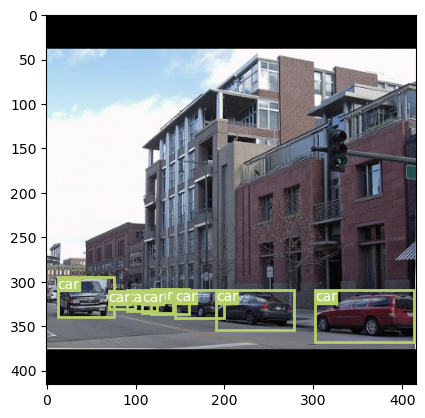

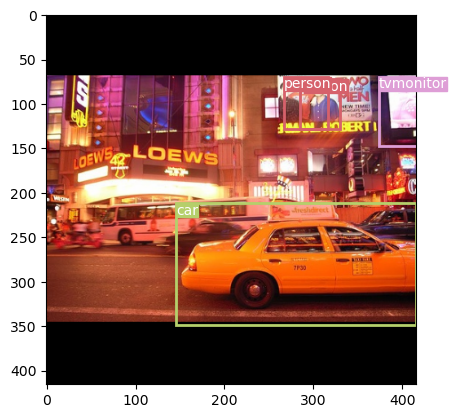

In [13]:
plot_couple_examples_test(model.cuda(), yolo_dm.test_dataloader(), 0.6, 0.5, scaled_anchors)

In [14]:
test_loader = yolo_dm.test_dataloader()
check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)
pred_boxes, true_boxes = get_evaluation_bboxes(
            test_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
print(f"MAP: {mapval.item()}")

100%|██████████| 310/310 [01:20<00:00,  3.85it/s]


Class accuracy is: 89.185371%
No obj accuracy is: 99.004776%
Obj accuracy is: 70.451645%


100%|██████████| 310/310 [11:03<00:00,  2.14s/it]


MAP: 0.49295657873153687


lr-Adam  train_loss  val_Class_Accuracy  val_No_Obj_Accuracy  \
step                                                                  
49    0.000020         NaN                 NaN                  NaN   
49         NaN   40.082420                 NaN                  NaN   
99    0.000031         NaN                 NaN                  NaN   
99         NaN   32.373543                 NaN                  NaN   
149   0.000042         NaN                 NaN                  NaN   

      val_Obj_Accuracy  test_Class_Accuracy  test_No_Obj_Accuracy  \
step                                                                
49                 NaN                  NaN                   NaN   
49                 NaN                  NaN                   NaN   
99                 NaN                  NaN                   NaN   
99                 NaN                  NaN                   NaN   
149                NaN                  NaN                   NaN   

      test_Obj_Accuracy  
step                     
49                  NaN  
49                  NaN  
99                  NaN  
99                  NaN  
149                 NaN

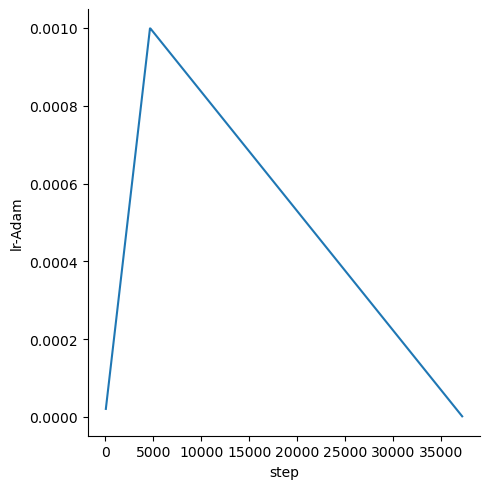

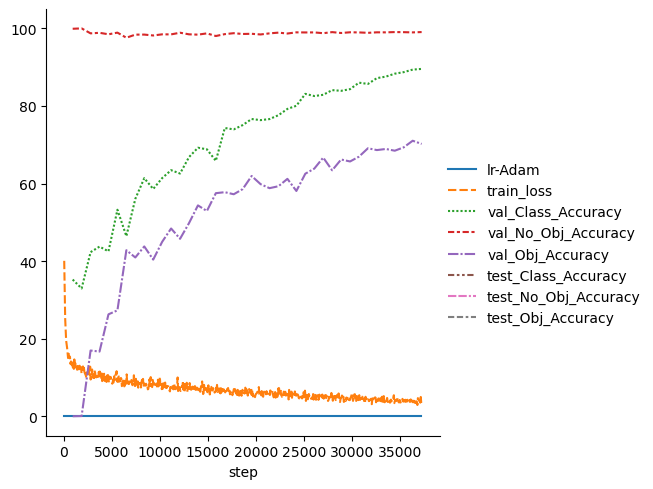

In [15]:
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["epoch"]
metrics.set_index("step", inplace=True)
sn.relplot(data=metrics['lr-Adam'], kind="line")
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")